# Student Name: Kanav Jamwal
# Student ID: 29554209

# Part A. Document Clustering
## EM for Document Clustering


In [12]:
library(SnowballC)
library(tm)

## 2. Implementation of Hard EM and Soft EM

In [13]:
# Written by Gholamreza Haffari and Borhan Kazimipour, July 2016
#======
#You are welcome to use this code for your submission if you would like to; otherwise, you are welcome to use your own code that you have developed so far. 

# The main aim is to help you folks to move forward to interesting parts of the Assessment, and to not get stuck in some implementation details.
# Carefully note the comments throughout the code, particularly theo nes relating to handle small numbers in the log space and how to prevent NaN 
# when normalising a non-negative vector to get probability distribution. 
#========


# You may need to install some packages:
#install.packages('tm')
#install.packages('SnowballC')

eps=1e-10
  
# reading the data
read.data <- function(file.name='./Task2A.txt', sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the labels (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  lapply(docs, function(x) x[1])
                           
  # store the unlabeled texts 
                           
  doc.id <- seq(1,length(docs))
                           
  docs <- data.frame(doc_id = doc.id, text = unlist(lapply(docs, function(x) x[2])))
                          
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}

## --- helper function ------------------------------------------------------------------ 
# Input:    logA1, logA2 ... logAn
# Output:   log(A1+A2+...+An)
#
# This function is needed to prevent numerical overflow/underflow when working with small numbers, 
# because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   
#
# Example: Suppose we are interested in p1*p2*p3 + q1*q2+q3 where all numbers are probabilities \in [0,1]
#          To prevent numerical errors, we do the computation in the log space and convert the result back using the exp function 
#          Hence our approach is to form the vector v = [log(p1)+log(p2)+log(p3) , log(q1)+log(q2)+log(q3)] 
#          Then get the results by: exp(logSum(v))
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

##--- Initialize model parameters randomly --------------------------------------------
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)                    # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}

##--- E Step for Document Clustering  --------------------------------------------
# this function currently implements the E-step of the soft-EM
# Student needs to modify this function if wants to make it Hard-EM 
#
E.step <- function(gamma, model, counts, type = 'soft'){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
  }
  
  # converting back from the log space 
  gamma <- exp(gamma)
        
 if(type == 'hard'){
    max.prob <- gamma == apply(gamma, 1, max) # for each point find the cluster with the maximum (estimated) probability
    gamma[max.prob] <- 1 # assign each point to the cluster with the highest probability
    gamma[!max.prob] <- 0 # remove points from clusters with lower probabilites
 }
    
    
  return (gamma)
}

##--- M Step for Document Clustering  --------------------------------------------
M.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters

 
  # M step: Student needs to write this part for soft/hard EM
  #......
  #
  # hint: before you normalise a vector so that it sums to 1, first add a small number (eps) to all elements of the vector.
  # for example, suppose you have a vector [n1,n2,n3] and you want to normalise it to make it a probability distribution. 
  # you first need to add eps to elements [n1+eps,n2+eps,n3+eps], then divide the elements by (n1+n2+n3+ 3*eps) so that the vecotr sums to 1. 
  # this prevents NaN for vectors where all elements aer zero such as [0,0,0] because after adding eps you have [eps,eps,eps] which 
  # results in the uniform distribution after normalisation.
    
  for (k in 1:K){
        # the relative cluster size  
        model$rho[k,1] <- sum(gamma[,k])/N       
    }
    
    # for mu
    for (k in 1:K){
        # initialze numerator of mu for each cluster (K) to 0
        num = 0
        
        # For every document
        for (n in 1:N){
            
            # numerator of mu = sum of (posterior prob (gamma) of each document in the cluster) X (each words in the document)
            num = num + gamma[n,k] * counts[,n]
        }
        
        # add a small number (eps = 1e-10)
        num = num + 1e-10
        
        # Probablity of each work occuring in a document assigned to cluster k 
        model$mu[k,] <- num/sum(num)
        
    }  


  # Return the result
  return (model)
}
                                                           
##--- EM for Document Clustering --------------------------------------------
EM <- function(counts, K=4, max.epoch=10, type = 'soft', seed=123456){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step for soft classification
    gamma <- E.step(gamma, model, counts, type)

    # M Step
    model <- M.step(gamma, model, counts)
   
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

##--- the training objective function --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

### 3.1 EM Hard Classification

In [14]:
### main body ##################################################################

# Reading documents 
## Note: sample.size=0 means all read all documents!
##(for develiopment and debugging use a smaller subset e.g., sample.size = 40)
data <- read.data(file.name='./Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat        
# below is toy data if you want to work with
# counts <- matrix(c(1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,1,0,0),nrow=3,ncol=6)

# calling the EM algorithm on the data
res.h <- EM(counts, K=4, max.epoch=5, type = 'hard')   

# visualization
## find the culster with the maximum probability (since we have soft assignment here)
label.hat.hard <- apply(res.h$gamma, 1, which.max) 
## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

[1] 2182952
[1] 1950123
[1] 1932782
[1] 1921394
[1] 1917574
[1] 1915679


### 3.2 EM Soft Classification

In [15]:
### main body ##################################################################

# Reading documents 
## Note: sample.size=0 means all read all documents!
##(for develiopment and debugging use a smaller subset e.g., sample.size = 40)
data <- read.data(file.name='./Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat        
# below is toy data if you want to work with
# counts <- matrix(c(1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,1,0,0),nrow=3,ncol=6)

# calling the EM algorithm on the data
res <- EM(counts, K=4, max.epoch=5,type='soft')   

# visualization
## find the culster with the maximum probability (since we have soft assignment here)
label.hat.soft <- apply(res$gamma, 1, which.max) 
## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

[1] 2178754
[1] 1949976
[1] 1933247
[1] 1923823
[1] 1917880
[1] 1915283


## 4.Visualisation using PCA

In [16]:
##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

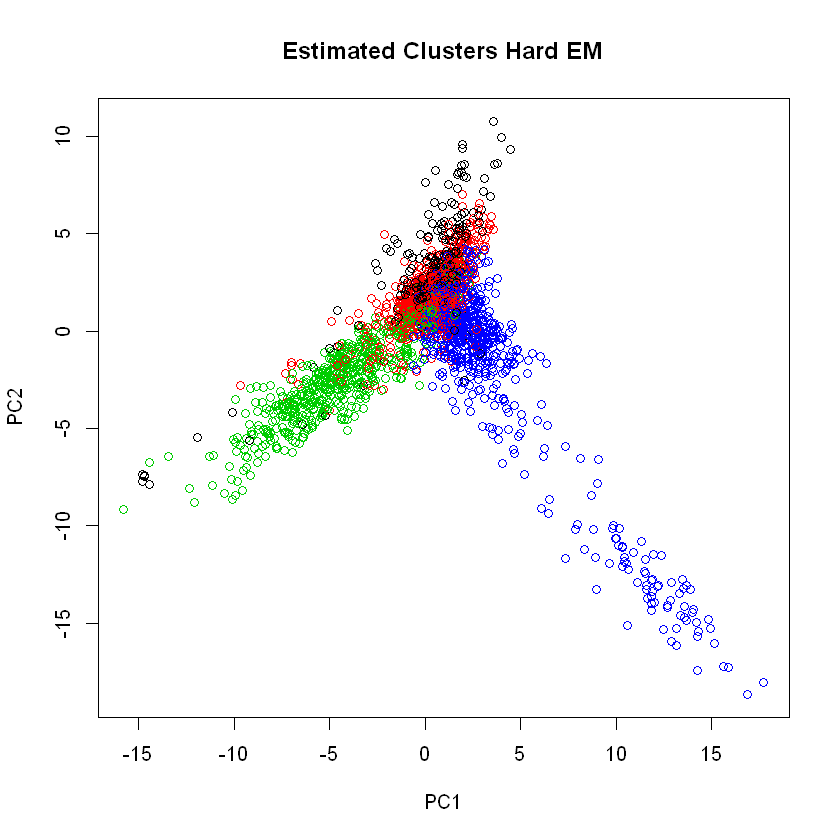

In [17]:
## visualize the stimated clusters
cluster.viz(t(counts), label.hat.hard, 'Estimated Clusters Hard EM')

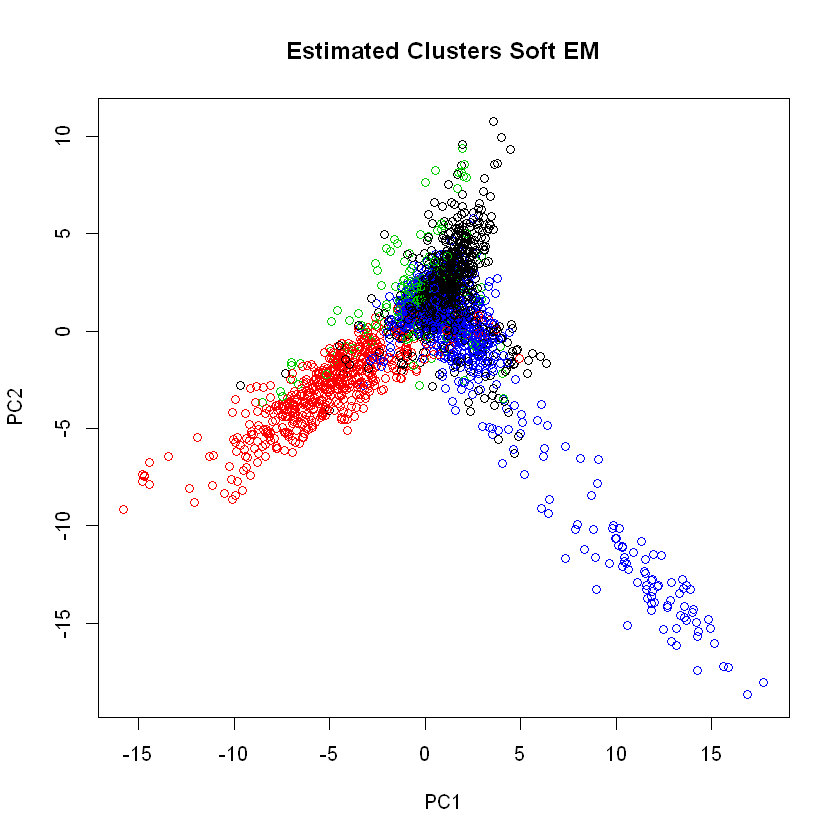

In [18]:
## visualize the stimated clusters
cluster.viz(t(counts), label.hat.soft, 'Estimated Clusters Soft EM')

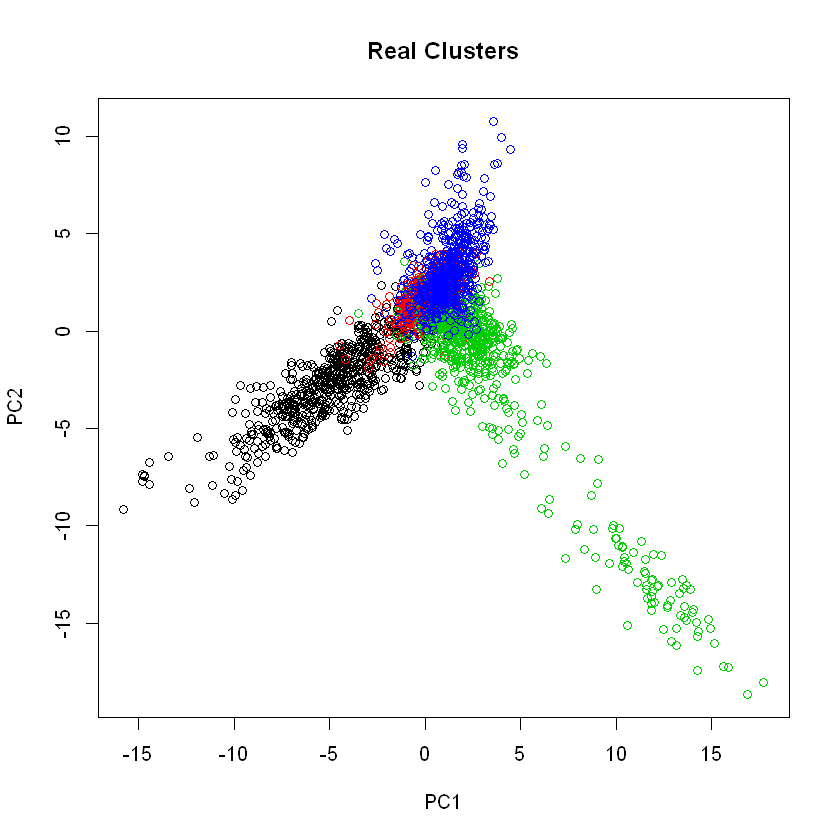

In [19]:
## visualize the real clusters
cluster.viz(t(counts), factor(unlist(data$labels)), 'Real Clusters')